<a href="https://colab.research.google.com/github/ZacharySBrown/vcu-scma440-2021q1/blob/master/examples/3d_stl_decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Fetch Data

Press the play button in Google Colab or press `Shift+Enter` execute the cell below to download and load the data and packages for this assignment

This will load four `pandas` `DataFrame` objects: `shampoo`,`housing`, `airline`, and `airline_series`.
Each of these is used in Makridakis Chapter 3. 

In [2]:
import pandas as pd
from numpy import log, abs, mean, exp
from IPython.display import display
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 16



!curl https://raw.githubusercontent.com/ZacharySBrown/vcu-scma440-2021q1/master/utils/fetch_e3.sh > fetch_e3.sh
!bash fetch_e3.sh

# Example
shampoo = pd.read_csv('shampoo_sales.csv', parse_dates=['date']).set_index('date')
housing = pd.read_csv('housing_sales.csv', parse_dates=['date']).set_index('date')
airline = pd.read_csv('airline.csv').set_index('year')
airline_series = pd.read_csv('airline_series.csv', parse_dates=['date']).set_index('date')
!pip install -U statsmodels

from IPython.display import display_html
def restartkernel() :
  print("restarting kernel to reflect package installation")
  display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

restartkernel()

from statsmodels.tsa.seasonal import STL

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   380  100   380    0     0   8260      0 --:--:-- --:--:-- --:--:--  8260
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   629  100   629    0     0   1616      0 --:--:-- --:--:-- --:--:--  1616
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3867  100  3867    0     0  13108      0 --:--:-- --:--:-- --:--:-- 13064
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   456  100   456    0     0   1535      0 --:--:-- --:--:-- --:--:--  1535
  % Total    % Received % Xferd  Average Speed   Tim

# Inspecting the Data

We'll start out with a simple time series plot of the `housing` `DataFrame`

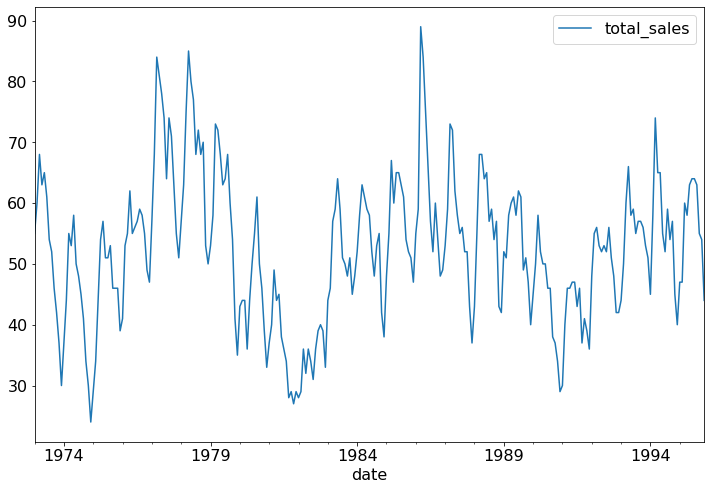

In [7]:
housing.plot()

# Creating an STL Decomposition

STL decomposition is implemented in the `statsmodels` library, under the seasonal time series analysis subpackage (`statsmodels.tsa.seasonal`). The STL implementation has already been imported for you in the first cell of this notebook:

`from statsmodels.tsa.seasonal import STL`

To create an STL model to decompose our data:

`stl = STL(_any_options_)`

We'll focus primarily on the following options:
* `endog`: Data to be decomposed
* `period`: Periodicity of the sequence
* `seasonal`: Length of ths seasonal smoother (odd integer)
* `trend`: Length of the trend smoother (odd integer)
* `seasonal_deg`: Degree of the seasonal LOESS (`0` linear, `1` for quadratic)
* `trend_deg`: Degree of the trend LOESS (`0` linear, `1` for quadratic)
* `robust`: Use weighting to control for outliers

To see _all_ the options for STL decomposition via LOESS, you can run `STL?` in any of the code cells in this notebook. 

Once you've defined an stl model with the options you want, you can then fit the model to the data by calling the `.fit()` function. 

For example:

```
stl = STL(
    endog=housing, 
    period=12, 
    seasonal=7,
    seasonal_deg=0, 
    trend_deg=0,
    robust=True
    )

results = stl.fit()
```

will fit a model and save the results of the fit to a set of results.

In [23]:
stl = STL(
    endog=housing, 
    period=12, 
    seasonal=7,
    seasonal_deg=0, 
    trend_deg=0,
    robust=True
    )
results = stl.fit()

# Plotting an STL Decomposition

To create a plot of the decomposition, you can simply call `results.plot()`

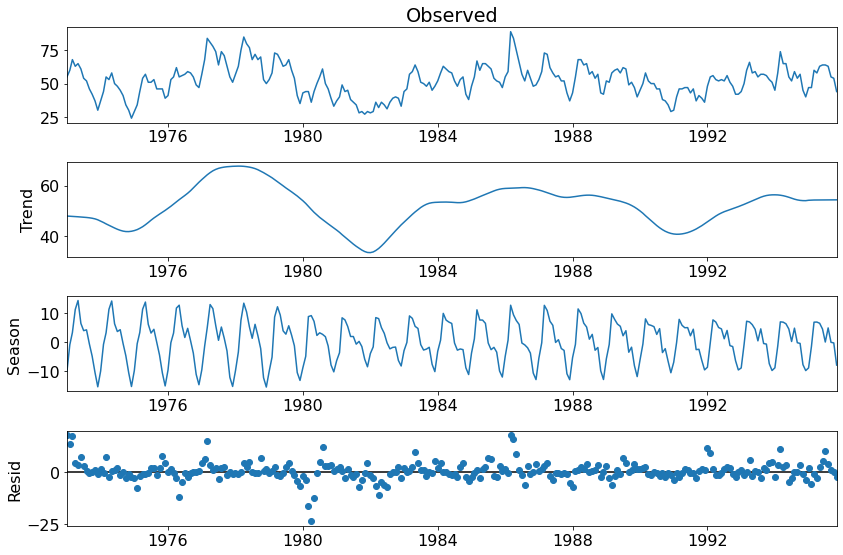

In [38]:
my_figure = results.plot()

The various parts of the decomposition can be acccessed from the results using the `.attribute` notation, e.g. to access the trend of the STL decomposition results, you can use `results.trend`

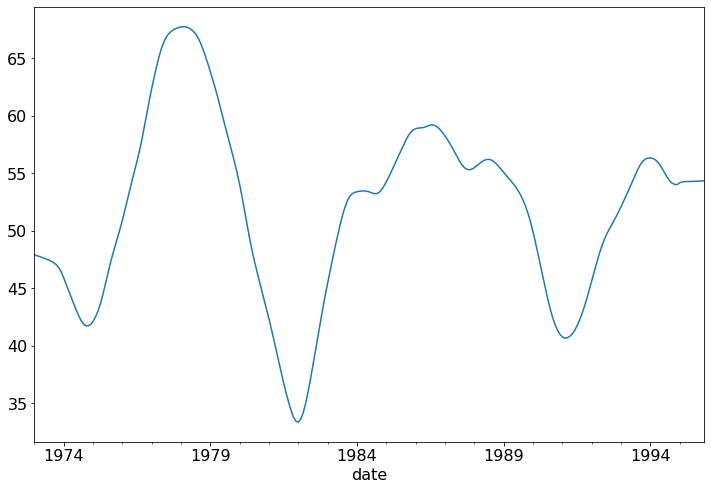

In [39]:
trend= results.trend
trend.plot()

The results provide access to the following:
* `observed`: The observed values that the decomposition was fit on (the original data)
* `trend`: The estimated  trend cycle
* `seasonal`: The estimated seasonal component
* `resid`: The irregular , or residual component of the fit
* `weights`: The final weights used in robust estimation
* `plot()`: Simple function to plot results

Note that `.plot()` doesn't plot the weights from robustness by default. `.plot() provides control over which components are plotted with an argument for each component:

```
my_figure = results.plot(
  observed=True, 
  seasonal=True, 
  trend=True, 
  resid=True, 
  weights=False
)
```

For example, to plot just the errors and the robustness weights:

```
my_figure = results.plot(
  observed=False, 
  seasonal=False, 
  trend=False, 
  resid=True, 
  weights=True
)
```

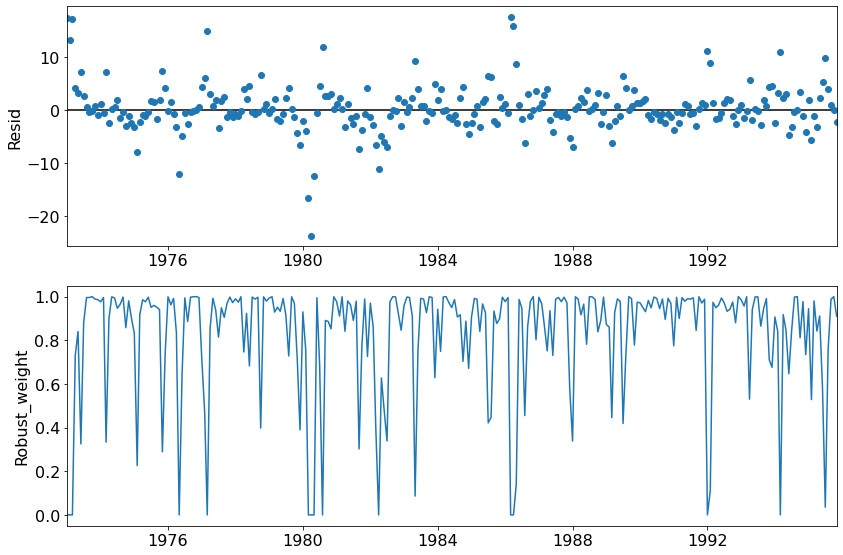

In [40]:
my_figure = results.plot(
  observed=False, 
  seasonal=False, 
  trend=False, 
  resid=True, 
  weights=True
)

# Comparing Decompositions

One straightforward metric for comparing the "goodness of fit" from one decomposition to another is to calculate the mean squared error (MSE) between the **original** data and the parts of the decomposition that reflect the pattern (the `trend` and `seasonal` components). Luckily, the `resid` contains exactly the errors remaining after the `trend` and `seasonal` have been removed. 

Therefore, to calculate the MSE for a given decomposition, we need to only square and take the mean of `results.resid`. 

To square a column of a `pandas` `DataFrame`, we use the syntax `data['column']**2`. As `results.resid` is already a single column, we can call `**2` diirectly on that. We can then use the `mean()` function to calculate the mean squared error.


In [53]:
squared_error = results.resid**2
mean_squared_error = squared_error.mean()
print(f"Mean Squared Error: {mean_squared_error}")

Mean Squared Error: 14.676045538999375


Below, we use several `for` loops in python to loop through multiple sets of STL decomposition options, calculate a decomposition and mse, then save the results to a `pandas` `DataFrame`. 

In [54]:
periods_list = [4, 12]
seasonal_list = [7, 15]
trend_list = [7, 15]
seasonal_deg_list = [0,1]
trend_deg_list = [0,1]
robust_list = [True, False]
from itertools import product

all_results = []
fits = []

for period in periods_list:
  for seasonal in seasonal_list:
    for trend in trend_list:
      for seasonal_deg in seasonal_deg_list:
        for trend_deg in trend_deg_list:
          for robust in robust_list:

            options = {
                'period': period, 
                'seasonal': seasonal, 
                'trend': trend, 
                'seasonal_deg': seasonal_deg, 
                'trend_deg': trend_deg, 
                'robust': robust
            }

            results = STL(
                endog=housing, 
                period=period, 
                seasonal=seasonal,
                seasonal_deg=seasonal_deg, 
                trend_deg=trend_deg,
                robust=robust
                ).fit()

            MSE = (results.resid**2).mean()

            options['mse'] = MSE
            all_results.append(options)
            fits.append(results)

all_results = pd.DataFrame(all_results)
all_results.sort_values('mse')

,period,seasonal,trend,seasonal_deg,trend_deg,robust,mse
31,4,15,15,1,1,False,9.596904
23,4,15,7,1,1,False,9.596904
27,4,15,15,0,1,False,9.652303
19,4,15,7,0,1,False,9.652303
21,4,15,7,1,0,False,10.035389
...,...,...,...,...,...,...,...
2,4,7,7,0,1,True,33.978190
8,4,7,15,0,0,True,38.373487
0,4,7,7,0,0,True,38.373487
4,4,7,7,1,0,True,40.714527


Let's take a look at the decomposition with the smallest mean squared error. We stored the `results` from each fit in a list called `fits`, and you can access the fit corresponding to index (row label) `i` from the `all_results` `DataFrame` by calling:

`fits[i]`

E.g. if you if you want to plot the fit corresponding to  row 31 from the `all_results` `DataFrame`, you would use:
```
results = fits[31]
my_figure = results.plot()
```

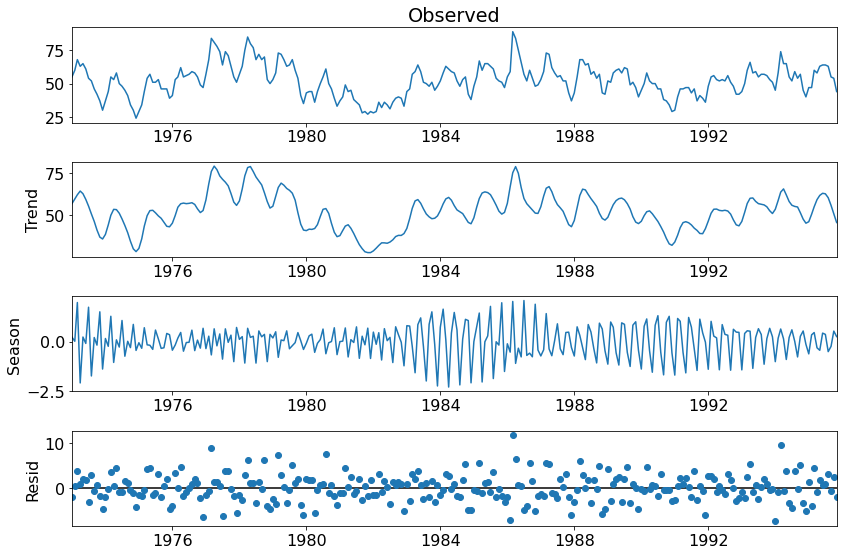

In [56]:
results = fits[31]
my_figure = results.plot()

Let's now take a look at the decomposition with the _largest_ MSE

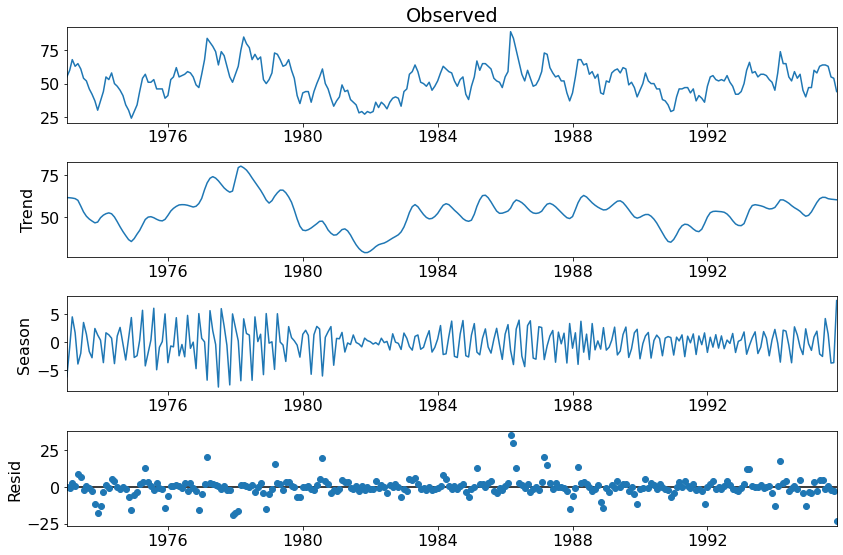

In [57]:
results = fits[12]
myfigure = results.plot()

Lastly, we can take a look at the distribution of residuals for each of these fits

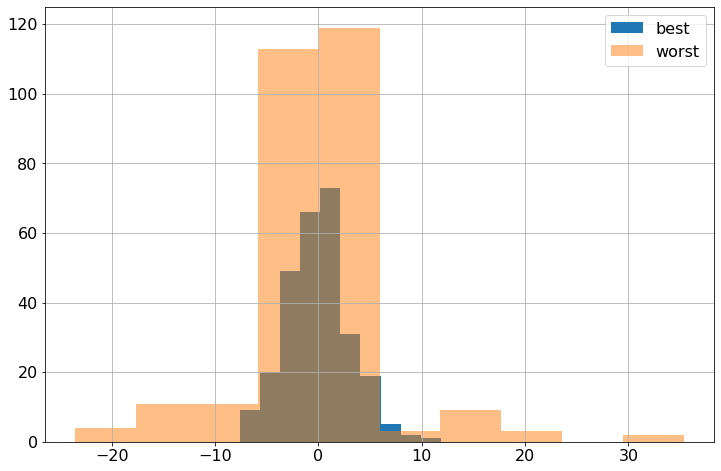

In [63]:
fits[31].resid.hist()
fits[12].resid.hist(alpha=0.5)

plt.legend(['best', 'worst'])